# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

Load and preview the dataset below.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

Using TensorFlow backend.


In [2]:
# Your code here; load and preview the dataset
raw = pd.read_csv("loan_final.csv")
raw.dropna(subset=["total_pymnt"], inplace=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.5+ MB


## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [3]:
# Your code here; appropriately define X and y and apply a trian test split
data_columns = ['loan_amnt', 
                'home_ownership', 
                'funded_amnt_inv', 
                'verification_status', 
                'emp_length', 
                'installment', 
                'annual_inc']

X = pd.DataFrame(raw[data_columns], columns=data_columns)
y = raw["total_pymnt"]

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [4]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28710 entries, 41266 to 14466
Data columns (total 7 columns):
loan_amnt              28710 non-null float64
home_ownership         28710 non-null object
funded_amnt_inv        28710 non-null float64
verification_status    28710 non-null object
emp_length             27979 non-null object
installment            28710 non-null float64
annual_inc             28707 non-null float64
dtypes: float64(4), object(3)
memory usage: 1.8+ MB


### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScalar()
* One hot encode categorical features with OneHotEncoder()

In [6]:
cont = ['loan_amnt', 
        'funded_amnt_inv', 
        'installment', 
        'annual_inc']

cate = ['home_ownership', 
        'verification_status', 
        'emp_length']

X_cont = X_train[cont]
X_cate = X_train[cate]

si = SimpleImputer()
si_cate = SimpleImputer(strategy="constant")
ss = StandardScaler()
ohe = OneHotEncoder(drop="first")

X_cont = si.fit_transform(X_cont)
X_cont = ss.fit_transform(X_cont)
X_cont = pd.DataFrame(X_cont, columns=cont)

X_cate = si_cate.fit_transform(X_cate)
X_cate = ohe.fit_transform(X_cate)
X_cate = pd.DataFrame(X_cate.todense(), columns=ohe.get_feature_names(input_features=cate))

X_train_pro = pd.concat([X_cont, X_cate], axis=1)

### Preprocess Your Holdout Set

Make sure to use your StandardScalar and OneHotEncoder that you already fit on the training set to transform your test set

In [7]:
X_cont = X_test[cont]
X_cate = X_test[cate]

X_cont = si.transform(X_cont)
X_cont = ss.transform(X_cont)
X_cont = pd.DataFrame(X_cont, columns=cont)

X_cate = si_cate.transform(X_cate)
X_cate = ohe.transform(X_cate)
X_cate = pd.DataFrame(X_cate.todense(), columns=ohe.get_feature_names(input_features=cate))

X_test_pro = pd.concat([X_cont, X_cate], axis=1)

In [8]:
y_train = (y_train-np.mean(y_train)) / np.std(y_train)

## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [9]:
# Your code here; define a function to evaluate a model object using K folds cross validation.

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    kf = KFold(n_splits=k, shuffle=True)
    
    score = []
    
    counter = 0
    
    for train, val in kf.split(features_train):
        counter += 1
        
        X_train, X_val = features_train.iloc[train], features_train.iloc[val]
        y_train, y_val = labels_train.iloc[train], labels_train.iloc[val]
        
        model = model_obj
        
        hist = model.fit(X_train, 
                         y_train, 
                         batch_size=32, 
                         epochs=n_epochs, 
                         validation_data=(X_val, y_val), 
                         verbose=0)
        
        score.append(model.evaluate(X_val, y_val))
        
        history = hist.history
        plt.figure()
        plt.plot(history["val_mse"])
        plt.plot(history["mse"])
        plt.legend(['Validation Set', 'Train Set'])
        plt.title("MSE vs number of epochs, fold {} of {} cross-validation".format(counter, k))
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.show()

    print("Mean Validation Score:", np.mean(score))
    print("Standard Deviation of Scores:", np.std(score))
        
    return

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [10]:
# Your code here; define and compile an initial model as described
input_dim = X_train_pro.shape[1]

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

2871/2871 [==============================] - 0s 8us/step


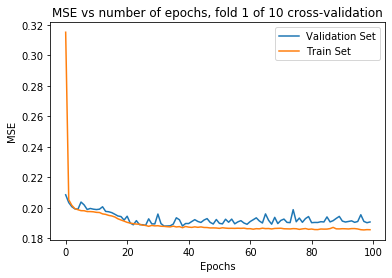

2871/2871 [==============================] - 0s 9us/step


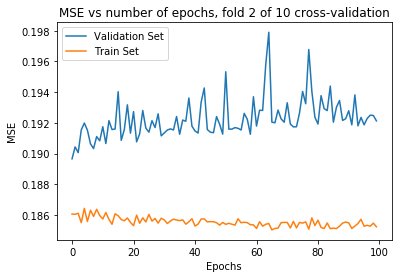

2871/2871 [==============================] - 0s 8us/step


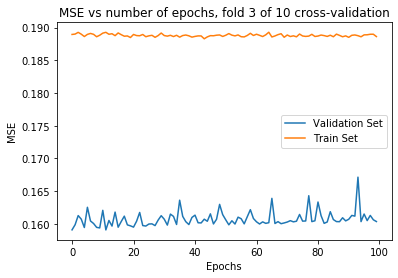

2871/2871 [==============================] - 0s 9us/step


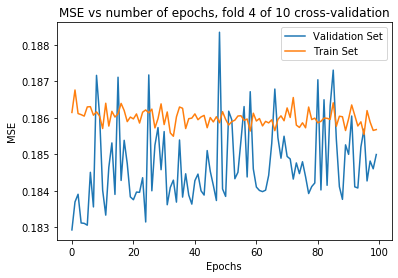

2871/2871 [==============================] - 0s 9us/step


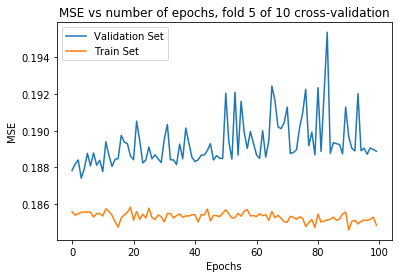

2871/2871 [==============================] - 0s 9us/step


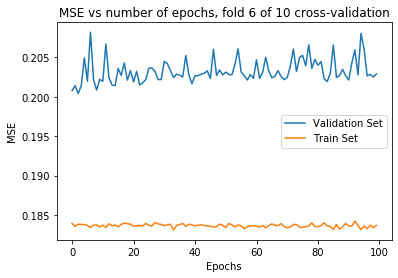

2871/2871 [==============================] - 0s 9us/step


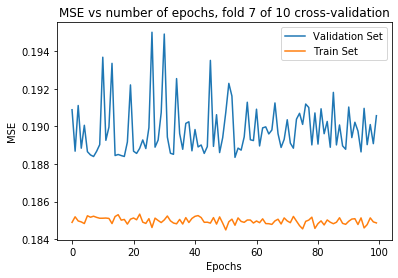

2871/2871 [==============================] - 0s 8us/step


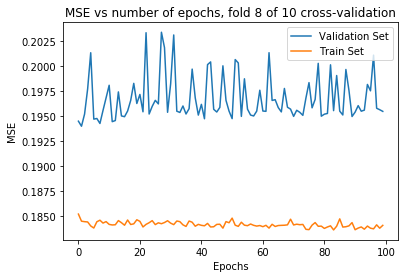

2871/2871 [==============================] - 0s 9us/step


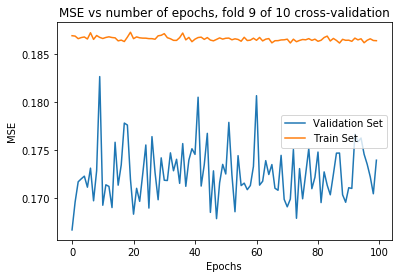

2871/2871 [==============================] - 0s 9us/step


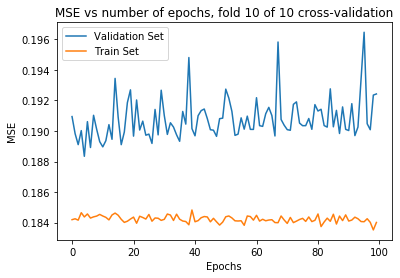

Mean Validation Score: 0.18723269206494772
Standard Deviation of Scores: 0.011379427092044227
Time Elapsed: 0:07:08.622008


In [11]:
# Your code here; use your k-folds function to evaluate the baseline model.
# ⏰ This cell may take several mintes to run
import time
import datetime

now = datetime.datetime.now()

k_folds(X_train_pro, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

2871/2871 [==============================] - 0s 9us/step


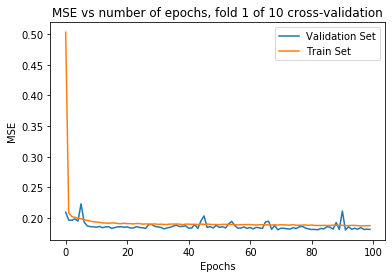

2871/2871 [==============================] - 0s 10us/step


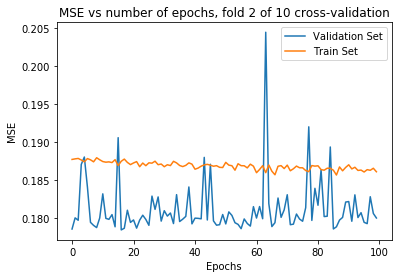

2871/2871 [==============================] - 0s 9us/step


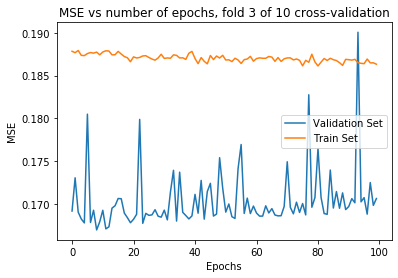

2871/2871 [==============================] - 0s 9us/step


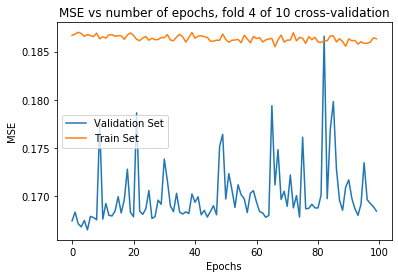

2871/2871 [==============================] - 0s 9us/step


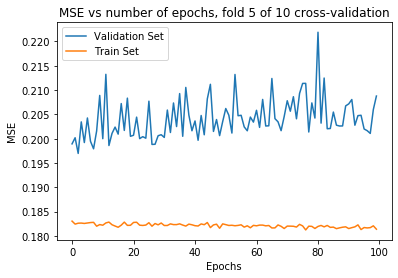

2871/2871 [==============================] - 0s 9us/step


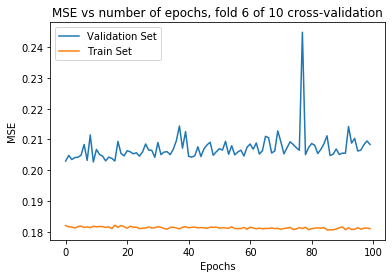

2871/2871 [==============================] - 0s 9us/step


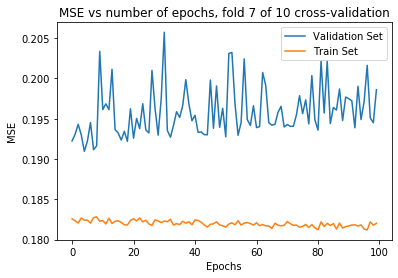

2871/2871 [==============================] - 0s 9us/step


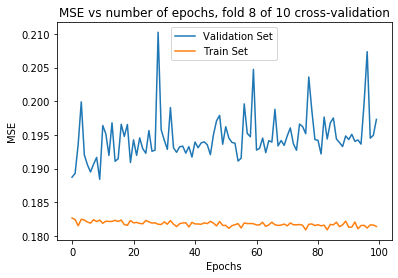

2871/2871 [==============================] - 0s 9us/step


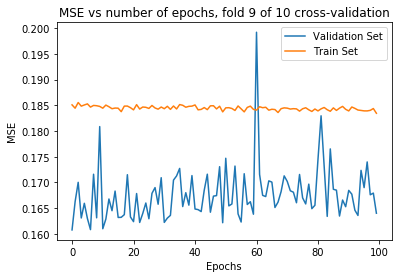

2871/2871 [==============================] - 0s 9us/step


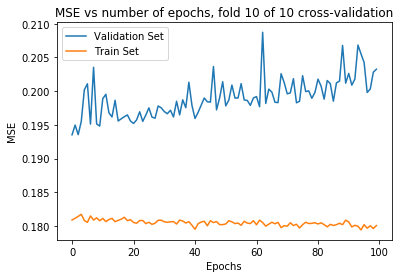

Mean Validation Score: 0.18807991116678452
Standard Deviation of Scores: 0.016262789653635618
Time Elapsed: 0:08:17.738552


In [12]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

2871/2871 [==============================] - 0s 10us/step


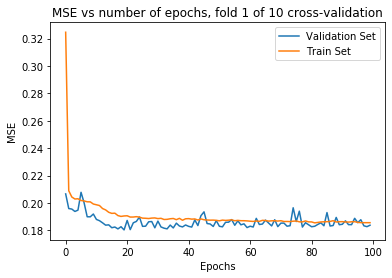

2871/2871 [==============================] - 0s 9us/step


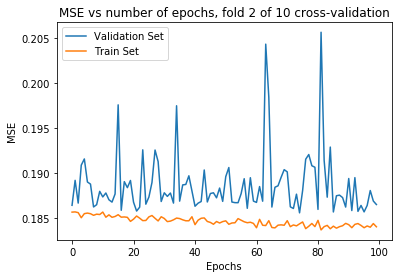

2871/2871 [==============================] - 0s 10us/step


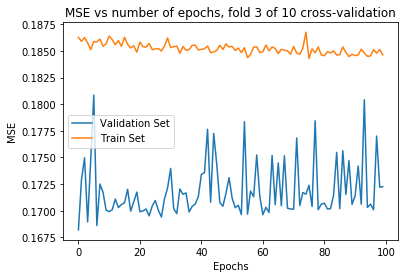

2871/2871 [==============================] - 0s 9us/step


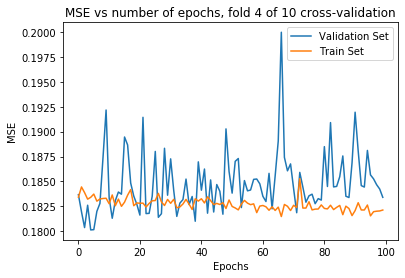

2871/2871 [==============================] - 0s 10us/step


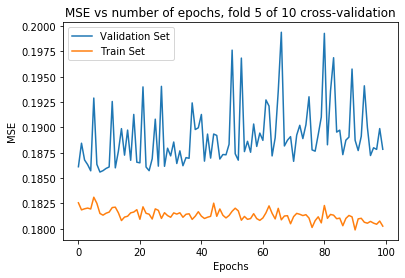

2871/2871 [==============================] - 0s 8us/step


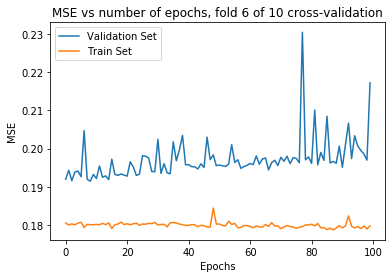

2871/2871 [==============================] - 0s 9us/step


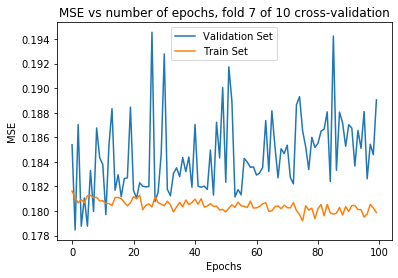

2871/2871 [==============================] - 0s 10us/step


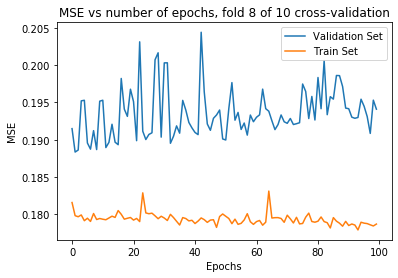

2871/2871 [==============================] - 0s 8us/step


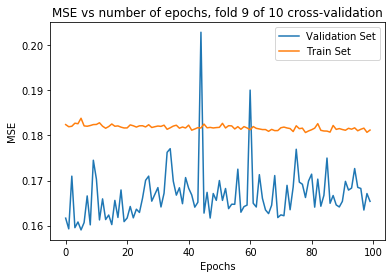

2871/2871 [==============================] - 0s 9us/step


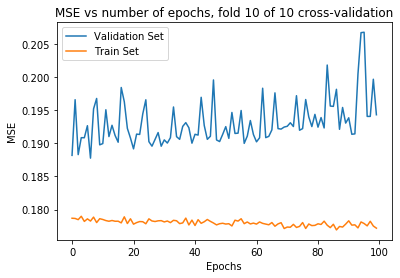

Mean Validation Score: 0.18736761120637507
Standard Deviation of Scores: 0.01313918779048349
Time Elapsed: 0:07:25.053000


In [13]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(35, activation="relu"))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

2871/2871 [==============================] - 0s 9us/step


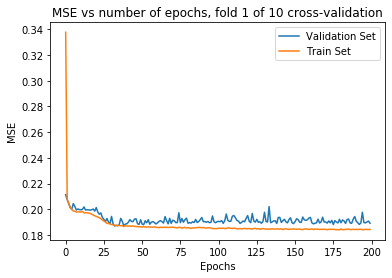

2871/2871 [==============================] - 0s 9us/step


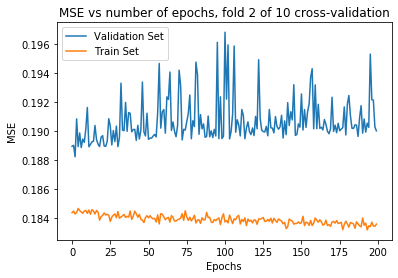

2871/2871 [==============================] - 0s 9us/step


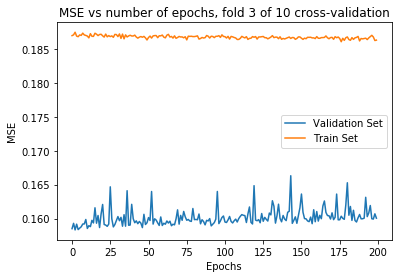

2871/2871 [==============================] - 0s 9us/step


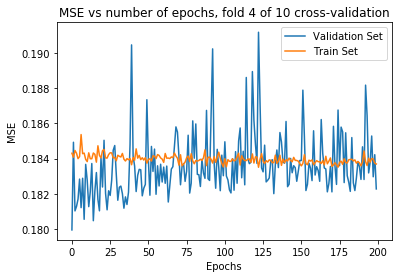

2871/2871 [==============================] - 0s 9us/step


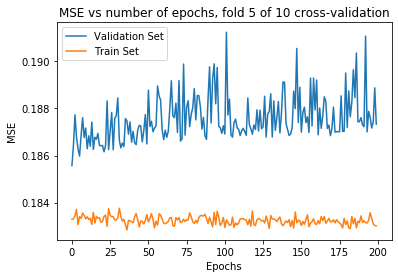

2871/2871 [==============================] - 0s 9us/step


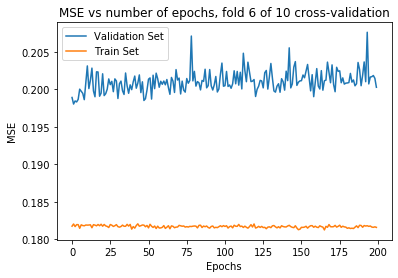

2871/2871 [==============================] - 0s 9us/step


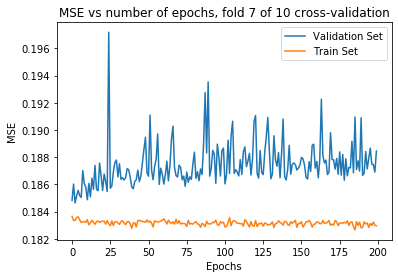

2871/2871 [==============================] - 0s 9us/step


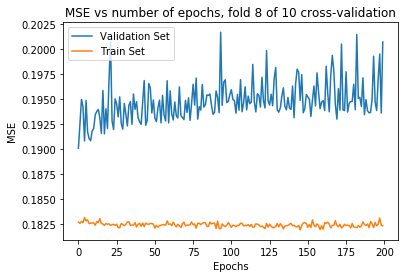

2871/2871 [==============================] - 0s 9us/step


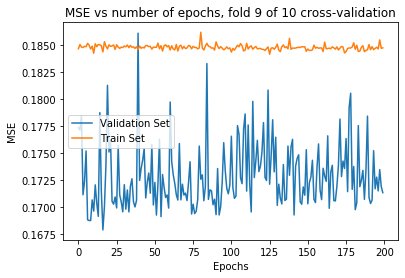

2871/2871 [==============================] - 0s 9us/step


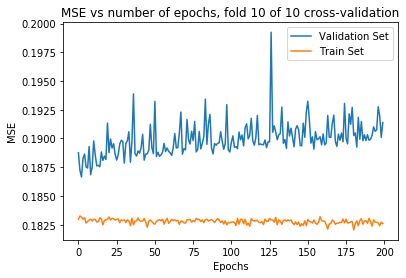

Mean Validation Score: 0.18611158973244463
Standard Deviation of Scores: 0.011772246438530245
Time Elapsed: 0:14:08.339721


In [14]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model, n_epochs=200)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

2871/2871 [==============================] - 0s 9us/step


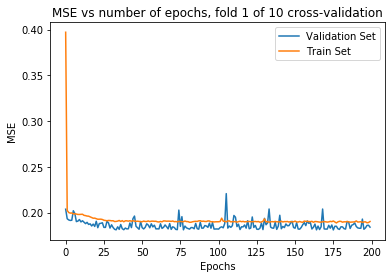

2871/2871 [==============================] - 0s 9us/step


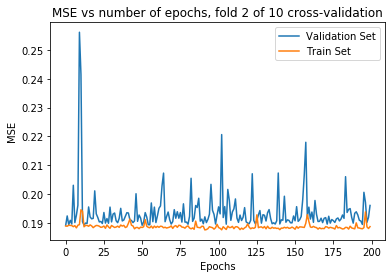

2871/2871 [==============================] - 0s 9us/step


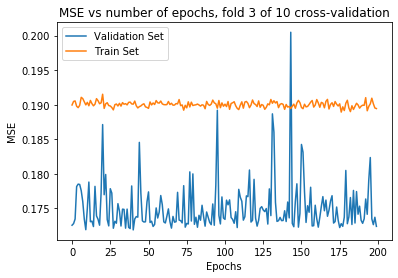

2871/2871 [==============================] - 0s 9us/step


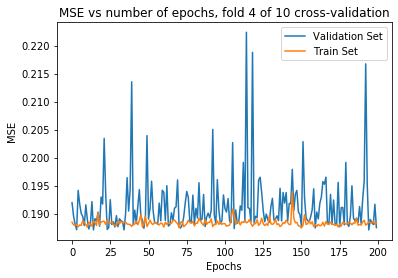

2871/2871 [==============================] - 0s 9us/step


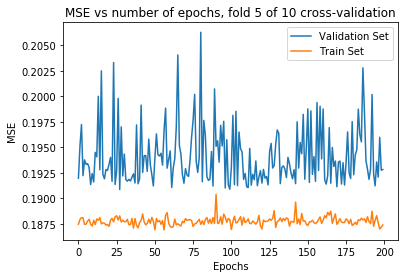

2871/2871 [==============================] - 0s 9us/step


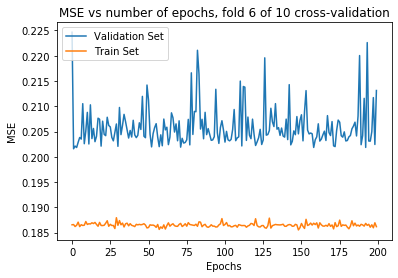

2871/2871 [==============================] - 0s 9us/step


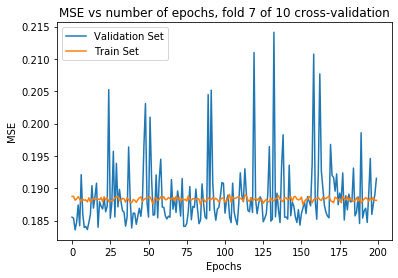

2871/2871 [==============================] - 0s 9us/step


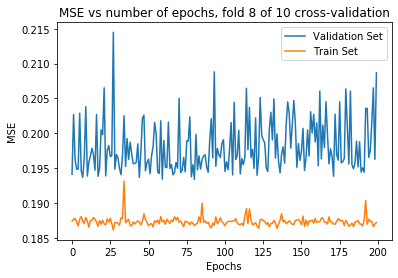

2871/2871 [==============================] - 0s 9us/step


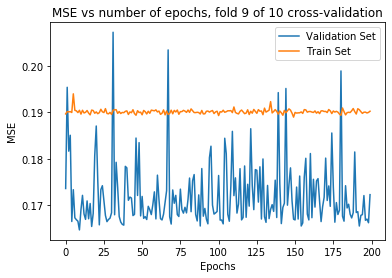

2871/2871 [==============================] - 0s 9us/step


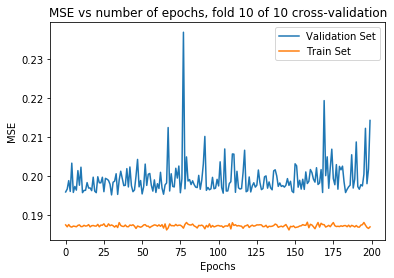

Mean Validation Score: 0.19502347794308536
Standard Deviation of Scores: 0.01446320745685388
Time Elapsed: 0:15:24.575346


In [15]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(35, activation="relu", kernel_regularizer=regularizers.l1(0.005)))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model, n_epochs=200)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

2871/2871 [==============================] - 0s 9us/step


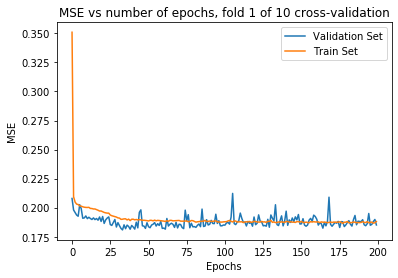

2871/2871 [==============================] - 0s 9us/step


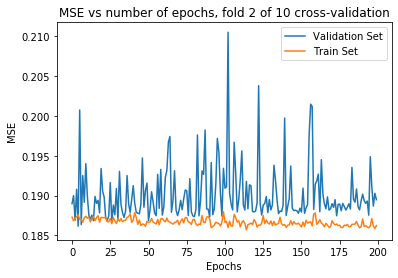

2871/2871 [==============================] - 0s 9us/step


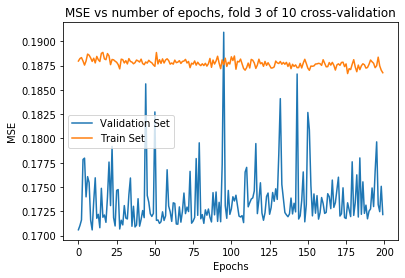

2871/2871 [==============================] - 0s 9us/step


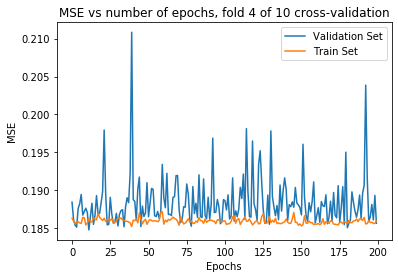

2871/2871 [==============================] - 0s 9us/step


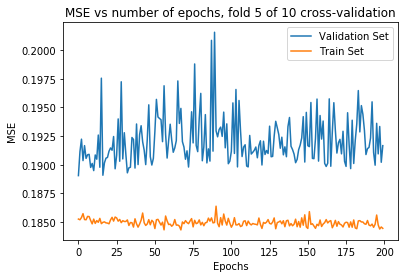

2871/2871 [==============================] - 0s 9us/step


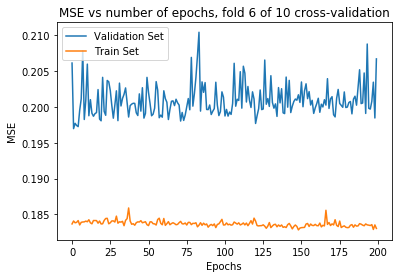

2871/2871 [==============================] - 0s 9us/step


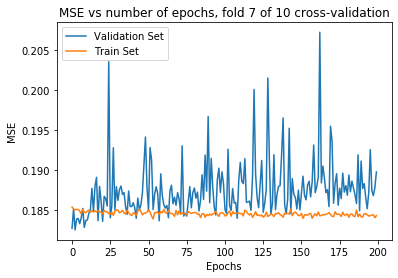

2871/2871 [==============================] - 0s 9us/step


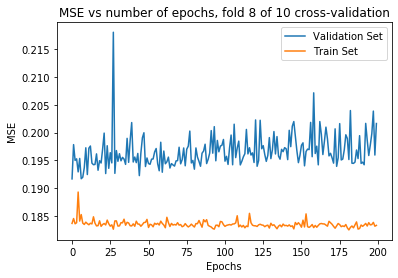

2871/2871 [==============================] - 0s 9us/step


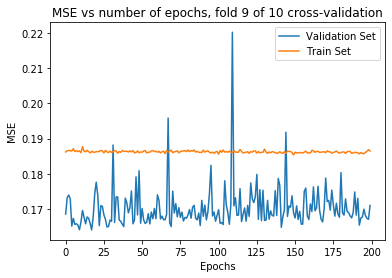

2871/2871 [==============================] - 0s 9us/step


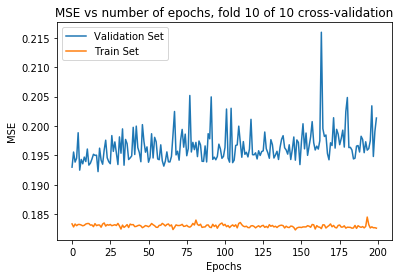

Mean Validation Score: 0.19027305901250394
Standard Deviation of Scores: 0.011281531832150785
Time Elapsed: 0:15:31.354417


In [16]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(35, activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model, n_epochs=200)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

2871/2871 [==============================] - 0s 9us/step


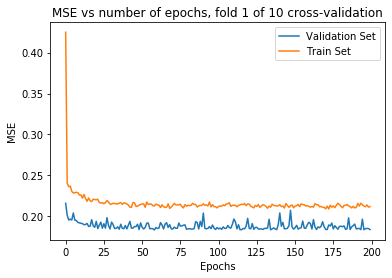

2871/2871 [==============================] - 0s 9us/step


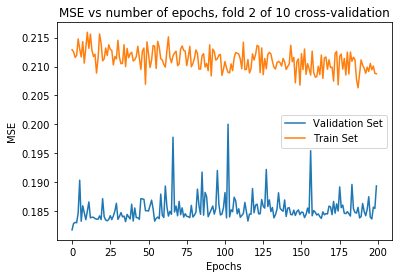

2871/2871 [==============================] - 0s 10us/step


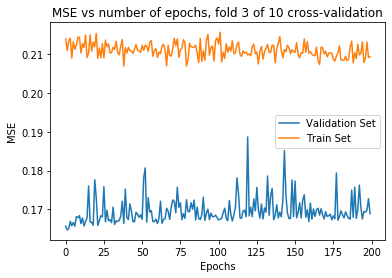

2871/2871 [==============================] - 0s 9us/step


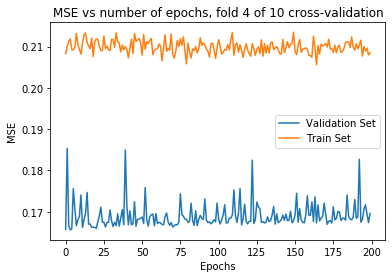

2871/2871 [==============================] - 0s 10us/step


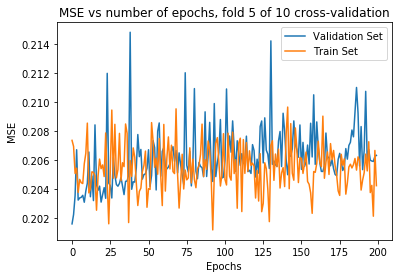

2871/2871 [==============================] - 0s 10us/step


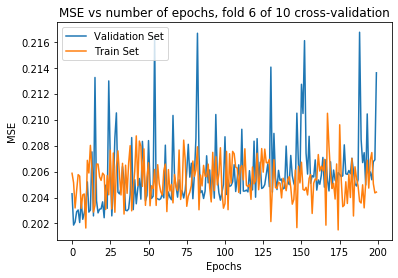

2871/2871 [==============================] - 0s 9us/step


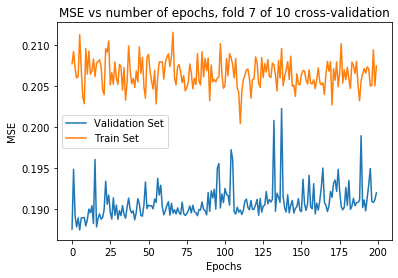

2871/2871 [==============================] - 0s 10us/step


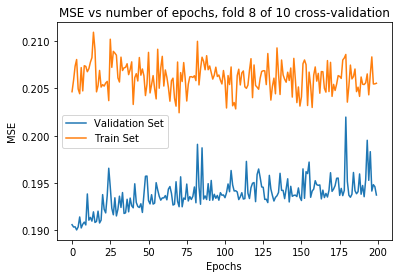

2871/2871 [==============================] - 0s 9us/step


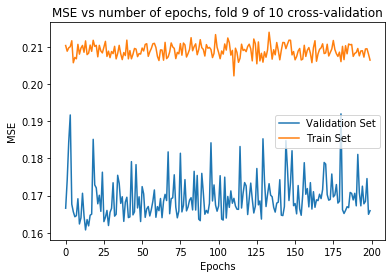

2871/2871 [==============================] - 0s 10us/step


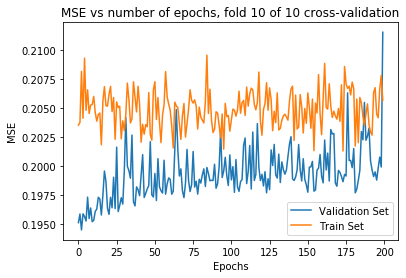

Mean Validation Score: 0.18948822546917693
Standard Deviation of Scores: 0.01667419659526524
Time Elapsed: 0:17:44.228388


In [17]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(35, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model, n_epochs=200)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

2871/2871 [==============================] - 0s 10us/step


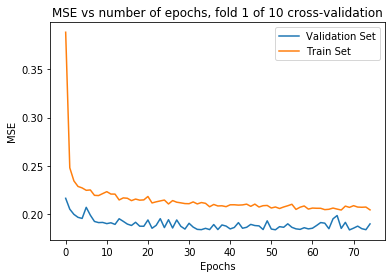

2871/2871 [==============================] - 0s 9us/step


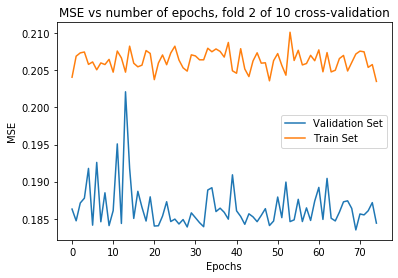

2871/2871 [==============================] - 0s 9us/step


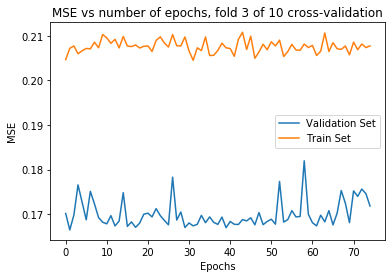

2871/2871 [==============================] - 0s 9us/step


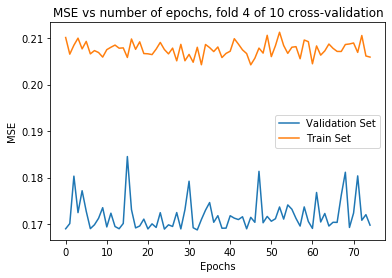

2871/2871 [==============================] - 0s 10us/step


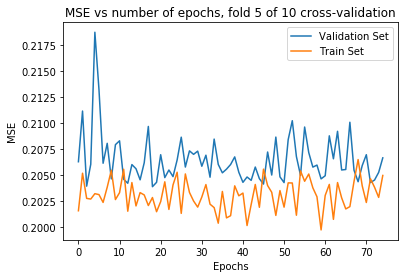

2871/2871 [==============================] - 0s 9us/step


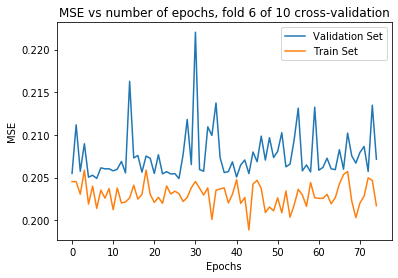

2871/2871 [==============================] - 0s 9us/step


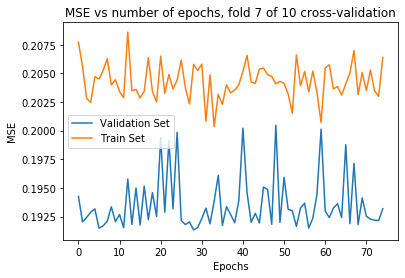

2871/2871 [==============================] - 0s 9us/step


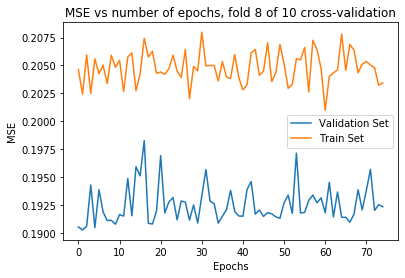

2871/2871 [==============================] - 0s 9us/step


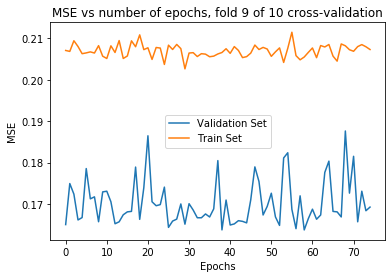

2871/2871 [==============================] - 0s 10us/step


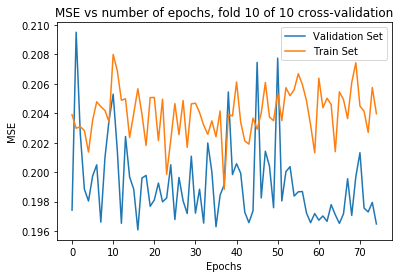

Mean Validation Score: 0.18900911310023963
Standard Deviation of Scores: 0.013424780615776708
Time Elapsed: 0:06:54.401088


In [18]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

k_folds(X_train_pro, y_train, model, n_epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

In [19]:
# Your code here; final model training on entire training set followed by evaluation on hold-out data
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation="relu", kernel_initializer="normal", input_dim=input_dim))
model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear", kernel_initializer="normal"))
model.compile(optimizer="sgd",
              loss="mse",
              metrics=["mse"])

model.fit(X_train_pro, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print("Time Elapsed:", elapsed)

print(model.evaluate(X_test_pro, y_test))

Epoch 1/75
28710/28710 [==============================] - 1s 24us/step - loss: 0.4173 - mse: 0.3590
Epoch 2/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2825 - mse: 0.2328
Epoch 3/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2671 - mse: 0.2249
Epoch 4/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2582 - mse: 0.2225
Epoch 5/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2532 - mse: 0.2227
Epoch 6/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2438 - mse: 0.2179
Epoch 7/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2355 - mse: 0.2134
Epoch 8/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2328 - mse: 0.2138
Epoch 9/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2278 - mse: 0.2114
Epoch 10/75
28710/28710 [==============================] - 1s 22us/step - loss: 0.2285 - mse: 0.2142

In [20]:
cont = ['loan_amnt', 
        'funded_amnt_inv', 
        'installment', 
        'annual_inc']

cate = ['home_ownership', 
        'verification_status', 
        'emp_length']

X_cont = X_val[cont]
X_cate = X_val[cate]

si = SimpleImputer()
si_cate = SimpleImputer(strategy="constant")
ss = StandardScaler()
ohe = OneHotEncoder(drop="first")

X_cont = si.fit_transform(X_cont)
X_cont = ss.fit_transform(X_cont)
X_cont = pd.DataFrame(X_cont, columns=cont)

X_cate = si_cate.fit_transform(X_cate)
X_cate = ohe.fit_transform(X_cate)
X_cate = pd.DataFrame(X_cate.todense(), columns=ohe.get_feature_names(input_features=cate))

X_val_pro = pd.concat([X_cont, X_cate], axis=1)

y_val = (y_val-np.mean(y_val)) / np.std(y_val)

model.evaluate(X_val_pro, y_val)

9571/9571 [==============================] - 0s 10us/step


[0.1965628538123867, 0.19484134018421173]

## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.